# 0. Install and Import Dependencies

In [1]:
!pip list

Package                         Version
------------------------------- -----------
absl-py                         1.4.0
apache-beam                     2.54.0
asttokens                       3.0.0
astunparse                      1.6.3
beautifulsoup4                  4.13.3
cachetools                      5.5.2
certifi                         2025.1.31
charset-normalizer              3.4.1
click                           8.1.8
cloudpickle                     2.2.1
colorama                        0.4.6
comm                            0.2.2
contourpy                       1.3.1
crcmod                          1.7
cycler                          0.12.1
debugpy                         1.8.13
decorator                       5.2.1
Deprecated                      1.2.14
dill                            0.3.1.1
dnspython                       2.6.1
docopt                          0.6.2
exceptiongroup                  1.2.2
executing                       2.2.0
fastavro                        1

In [2]:
%pip install opencv-python matplotlib imageio gdown tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt


In [4]:
import imageio

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [7]:
import gdown

In [8]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=a02e9f1f-511d-4567-915d-12a7bdf63c3f
To: c:\Users\KIIT\OneDrive\Desktop\python\LIP_READING\data.zip
 38%|███▊      | 162M/423M [14:40<25:25, 171kB/s]  

KeyboardInterrupt: 

 38%|███▊      | 162M/423M [14:50<25:25, 171kB/s]

In [ ]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [ ]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [ ]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [ ]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [ ]:
# test_path = bytes.decode(test_path.numpy())

In [ ]:
# hi = tf.convert_to_tensor(test_path).numpy().decode('utf-8')
# hi

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

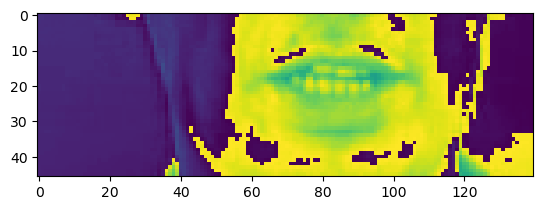

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [ ]:
len(train)

450

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

2

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
# len(sample)

In [ ]:
val = sample.next(); val[0]

array([[[[[1.3946624 ],
          [1.3946624 ],
          [1.3946624 ],
          ...,
          [0.1549625 ],
          [0.23244374],
          [0.27118436]],

         [[1.3946624 ],
          [1.3946624 ],
          [1.3946624 ],
          ...,
          [0.1549625 ],
          [0.27118436],
          [0.309925  ]],

         [[1.3171811 ],
          [1.3171811 ],
          [1.3171811 ],
          ...,
          [0.1549625 ],
          [0.07748125],
          [0.07748125]],

         ...,

         [[0.8910343 ],
          [0.8910343 ],
          [0.8910343 ],
          ...,
          [9.723896  ],
          [9.801377  ],
          [9.762637  ]],

         [[0.85229367],
          [0.85229367],
          [0.85229367],
          ...,
          [9.607675  ],
          [9.723896  ],
          [9.723896  ]],

         [[0.85229367],
          [0.85229367],
          [0.85229367],
          ...,
          [9.646415  ],
          [9.723896  ],
          [9.685156  ]]],


        [[[1.3559

In [ ]:

# for i in range (50):
#     val = sample.next()
    
#     print(i,val[0][0][0][0][0])
#     print(tf.strings.reduce_join([num_to_char(word) for word in val[1][0]]))
#     yhat = model.predict(val[0])
#     print(tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)]))
#     print(tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]]))

In [ ]:
# imageio.mimsave('./animation.gif', val[0][0], fps=10)

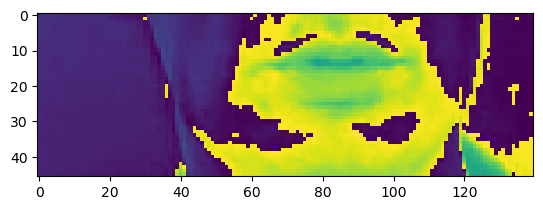

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set green by j one soon'>

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# url = 'https://drive.google.com/file/d/1fyZoYgqZw_aRa66kiOR6J8XLu3Y9wfMg/view?usp=sharing'
# url = 'https://drive.google.com/u/0/uc?id=1JAmcd2v0JcZStgs69VytgqwGJMlhNeaT&export=download'
# output = 'check.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('check.zip', 'models')

In [ ]:
# model.load_weights('./models/models/checkpoint')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
5*17*75

6375

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=46, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction 

In [ ]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [ ]:
# model.load_weights('./models/checkpoint')

In [ ]:
test_data = data.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
sample[0].shape

(2, 75, 46, 140, 1)

In [ ]:
sample[1].shape

(2, 40)

In [ ]:
sample[1]

array([[ 2,  9, 14, 39,  2, 12, 21,  5, 39,  9, 14, 39, 18, 39, 19,  9,
        24, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [16, 12,  1,  3,  5, 39,  2, 12, 21,  5, 39, 23,  9, 20,  8, 39,
         3, 39,  5,  9,  7,  8, 20, 39, 14, 15, 23,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 3s 3s/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in r six now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place blue with c eight now'>]

In [ ]:
# for i in range (50):
#     val = sample.next()
    
# #     print(i,val[0][0][0][0][0])
#     og = tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])
#     print(og)
#     yhat = model.predict(val[0])
# #     print(tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)]))
# #     print(tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]]))
#     decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
#     predicted = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
#     print(predicted)

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'o'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'o'>]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bbbf7s.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue by f seven soon'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 911ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'o'>]

In [ ]:
len(test)

50

# Accuracy Analysis

### On 50-Epoch Trained Model

In [ ]:
url = 'https://drive.google.com/u/0/uc?id=1JAmcd2v0JcZStgs69VytgqwGJMlhNeaT&export=download'
output = 'check.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('check.zip', 'models')

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1JAmcd2v0JcZStgs69VytgqwGJMlhNeaT&export=download
From (redirected): https://drive.google.com/uc?id=1JAmcd2v0JcZStgs69VytgqwGJMlhNeaT&export=download&confirm=t&uuid=c0de1440-dd0d-4a6f-8387-401c0a9e722e
To: c:\Users\KIIT\OneDrive\Desktop\python\LIP_READING\check.zip
100%|██████████| 95.3M/95.3M [00:05<00:00, 17.0MB/s]


['models\\models/checkpoint',
 'models\\models/checkpoint.index',
 'models\\models/checkpoint.data-00000-of-00001']

In [ ]:
model.load_weights('models\models\checkpoint')

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [ ]:
test_data = data.as_numpy_iterator()

In [ ]:
def levenshtein_distance(str1, str2):
    len_str1 = len(str1) + 1
    len_str2 = len(str2) + 1

    # Initialize a matrix to store edit distances
    matrix = [[0] * len_str2 for _ in range(len_str1)]

    # Initialize the first row and column of the matrix
    for i in range(len_str1):
        matrix[i][0] = i
    for j in range(len_str2):
        matrix[0][j] = j

    # Fill in the matrix using dynamic programming
    for i in range(1, len_str1):
        for j in range(1, len_str2):
            cost = 0 if str1[i - 1] == str2[j - 1] else 1
            matrix[i][j] = min(
                matrix[i - 1][j] + 1,      # Deletion
                matrix[i][j - 1] + 1,      # Insertion
                matrix[i - 1][j - 1] + cost  # Substitution
            )

    return matrix[len_str1 - 1][len_str2 - 1]

def calculate_word_error_rate(reference, hypothesis):
    reference_words = reference.split()
    hypothesis_words = hypothesis.split()

    # Calculate Levenshtein distance between reference and hypothesis words
    distance = levenshtein_distance(reference_words, hypothesis_words)

    # Calculate Word Error Rate
    wer = distance / len(reference_words)
    return wer

def calculate_sentence_error_rate(reference, hypothesis):
    # Calculate Levenshtein distance between reference and hypothesis sentences
    distance = levenshtein_distance(reference, hypothesis)

    # Calculate Sentence Error Rate
    ser = distance / len(reference)
    return ser

In [ ]:
word_error_rates_for_model1=[]
sentence_error_rates_for_model1=[]

In [ ]:
for i in range (500):
    try:
        sample = test_data.next()

        #     print(i,val[0][0][0][0][0])
        og = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]
        #     og = tf.strings.reduce_join([num_to_char(word) for word in sample[1][0]])

        yhat = model.predict(sample[0])
        #     print(tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)]))
        #     print(tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]]))
        decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
        predicted = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]


        reference_string = str(og[1])[11:-25]
        hypothesis_string = str(predicted[1])[11:-25]

        wer = calculate_word_error_rate(reference_string, hypothesis_string)
        ser = calculate_sentence_error_rate(reference_string, hypothesis_string)

        word_error_rates_for_model1.append(wer)
        sentence_error_rates_for_model1.append(ser)

        if i<10: # print results for first 10 sentences

            print(og[1])
            print("Real Sentence",str(og[1])[11:-25])

            print(predicted[1])
            print("Sentence Predicted",str(predicted[1])[11:-25])

            print(f"Word Error Rate: {wer * 100:.2f}%")
            print(f"Sentence Error Rate: {ser * 100:.2f}%")

            print()
    except:
        pass
    

1/1 [==============================] - 2s 2s/step
tf.Tensor(b'lay white with m zero now', shape=(), dtype=string)
Real Sentence 'lay white with m zero now'
tf.Tensor(b'lay white with zero now', shape=(), dtype=string)
Sentence Predicted 'lay white with zero now'
Word Error Rate: 16.67%
Sentence Error Rate: 7.41%

1/1 [==============================] - 1s 1s/step
tf.Tensor(b'place green with z zero please', shape=(), dtype=string)
Real Sentence 'place green with z zero please'
tf.Tensor(b'place green with z zero please', shape=(), dtype=string)
Sentence Predicted 'place green with z zero please'
Word Error Rate: 0.00%
Sentence Error Rate: 0.00%

1/1 [==============================] - 1s 1s/step
tf.Tensor(b'set red by u nine again', shape=(), dtype=string)
Real Sentence 'set red by u nine again'
tf.Tensor(b'set red by u nine again', shape=(), dtype=string)
Sentence Predicted 'set red by u nine again'
Word Error Rate: 0.00%
Sentence Error Rate: 0.00%

1/1 [==============================] 

In [ ]:
mean_wer=sum(word_error_rates_for_model1)/len(word_error_rates_for_model1)
mean_ser=sum(sentence_error_rates_for_model1)/len(sentence_error_rates_for_model1)

print("For Model 1")
print(f"Mean Word Error Rate: {mean_wer * 100:.2f}%")
print(f"Mean Sentence Error Rate: {mean_ser * 100:.2f}%")

For Model 1
Mean Word Error Rate: 14.41%
Mean Sentence Error Rate: 6.09%


In [ ]:
# print("Max For Model 1")
# print(f"Mean Word Error Rate: {max(word_error_rates_for_model1) * 100:.2f}%")
# print(f"Mean Sentence Error Rate: {max(sentence_error_rates_for_model1) * 100:.2f}%")

In [ ]:
len(word_error_rates_for_model1)

500

### On 96-Epoch trained model

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=c2c60469-d3cb-409c-a3d7-219db9b2ef63
To: c:\Users\KIIT\OneDrive\Desktop\python\LIP_READING\checkpoints.zip
100%|██████████| 94.5M/94.5M [00:35<00:00, 2.65MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [ ]:
model.load_weights('.\models\checkpoint')

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [ ]:
test_data = data.as_numpy_iterator()

In [ ]:
word_error_rates_for_model2=[]
sentence_error_rates_for_model2=[]

In [ ]:
for i in range (500):
    sample = test_data.next()
    
#     print(i,val[0][0][0][0][0])
    og = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]
#     og = tf.strings.reduce_join([num_to_char(word) for word in sample[1][0]])

    yhat = model.predict(sample[0])
#     print(tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)]))
#     print(tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]]))
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
    predicted = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

    
    reference_string = str(og[1])[11:-25]
    hypothesis_string = str(predicted[1])[11:-25]

    wer = calculate_word_error_rate(reference_string, hypothesis_string)
    ser = calculate_sentence_error_rate(reference_string, hypothesis_string)
    
    word_error_rates_for_model2.append(wer)
    sentence_error_rates_for_model2.append(ser)
    
    if i<10: # print results for first 10 sentences
    
        print(og[1])
        print("Real Sentence",str(og[1])[11:-25])

        print(predicted[1])
        print("Sentence Predicted",str(predicted[1])[11:-25])

        print(f"Word Error Rate: {wer * 100:.2f}%")
        print(f"Sentence Error Rate: {ser * 100:.2f}%")

        print()
    

1/1 [==============================] - 2s 2s/step
tf.Tensor(b'place red by d two please', shape=(), dtype=string)
Real Sentence 'place red by d two please'
tf.Tensor(b'place red by d two please', shape=(), dtype=string)
Sentence Predicted 'place red by d two please'
Word Error Rate: 0.00%
Sentence Error Rate: 0.00%

1/1 [==============================] - 2s 2s/step
tf.Tensor(b'set green with d three again', shape=(), dtype=string)
Real Sentence 'set green with d three again'
tf.Tensor(b'set green with d three again', shape=(), dtype=string)
Sentence Predicted 'set green with d three again'
Word Error Rate: 0.00%
Sentence Error Rate: 0.00%

1/1 [==============================] - 2s 2s/step
tf.Tensor(b'lay blue with e five soon', shape=(), dtype=string)
Real Sentence 'lay blue with e five soon'
tf.Tensor(b'lay blue with five soon', shape=(), dtype=string)
Sentence Predicted 'lay blue with five soon'
Word Error Rate: 16.67%
Sentence Error Rate: 7.41%

1/1 [==============================] 

In [ ]:
len(word_error_rates_for_model2)

500

In [ ]:
mean_wer=sum(word_error_rates_for_model2)/len(word_error_rates_for_model2)
mean_ser=sum(sentence_error_rates_for_model2)/len(sentence_error_rates_for_model2)

print("For Model 2")
print(f"Mean Word Error Rate: {mean_wer * 100:.8f}%")
print(f"Mean Sentence Error Rate: {mean_ser * 100:.8f}%")

For Model 2
Mean Word Error Rate: 1.86666667%
Mean Sentence Error Rate: 0.72660723%


In [ ]:
# print("Max For Model 2")
# print(f"Mean Word Error Rate: {max(word_error_rates_for_model2) * 100:.8f}%")
# print(f"Mean Sentence Error Rate: {max(sentence_error_rates_for_model2) * 100:.8f}%")

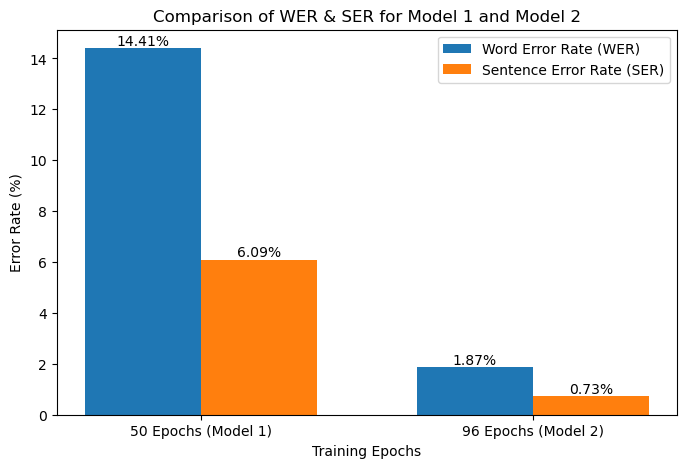

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your results
epochs = ["50 Epochs (Model 1)", "96 Epochs (Model 2)"]
wer_values = [14.41, 1.86666667]  # Word Error Rate (%)
ser_values = [6.09, 0.72660723]   # Sentence Error Rate (%)

# Plot
x = np.arange(len(epochs))  # Label positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, wer_values, width, label="Word Error Rate (WER)")
rects2 = ax.bar(x + width/2, ser_values, width, label="Sentence Error Rate (SER)")

# Labels
ax.set_xlabel("Training Epochs")
ax.set_ylabel("Error Rate (%)")
ax.set_title("Comparison of WER & SER for Model 1 and Model 2")
ax.set_xticks(x)
ax.set_xticklabels(epochs)
ax.legend()

# Display values on top of bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, f"{height:.2f}%", ha='center', va='bottom')

plt.show()
